Import Packages

In [19]:
import xarray as xr
import numpy as np
import pandas as pd
import packaging
import matplotlib.pyplot as plt
import netCDF4
import math

Define Functions

In [20]:

def read_csv(filename):
    '''Read in data from csv, assign headers, set datatypes, perform unit conversions if necessary, and find time step for
       the dataset in minutes.'''
# read data from csv
    headers = ['datetime', 'pr']
    dtypes = {'col1': 'str', 'col2': 'float'}
    date_cols = ['datetime']
    storms_data = pd.read_csv(filename, dtype = dtypes, header=None, names = headers, parse_dates = date_cols)
    
    # perform unit conversions
    storms_data.loc[ : , 'pr'] = storms_data.loc[ : , 'pr']

    # determine time step by subtracting one datetime from another
    TS = storms_data.loc[1, 'datetime'] - storms_data.loc[0, 'datetime']
    # convert time delta type to int type in minutes
    TS = int(TS.total_seconds() / 60)
    
    return storms_data

def read_netcdf4(filename):
    '''Read in data from netcdf4, assign headers, set datatypes, perform unit conversions if necessary'''
    # read in netcdf4 data to xarray
    storms_data = xr.open_dataset(filename)
    # convert xarray dataarray to pandas dataframe
    storms_data = storms_data.RAINRATE.to_dataframe()
    # get rid of lat long columns that could stay without causing any issues, but I spent ten minutes trying to get it to work, 
    # so they will remain removed
    storms_data = storms_data.drop(['lat', 'lon'], axis=1)
    # default index is multiindex. drop the additonal levels
    storms_data = storms_data.droplevel(['x', 'y'])
    # datetime was being used as the index, not one of the columns. Change it into a column and reset index
    storms_data['datetime'] = storms_data.index
    storms_data = storms_data.reset_index(drop = True)
    # convert datetime column from string to datetime
    storms_data['datetime']= pd.to_datetime(storms_data['datetime'])
    # rename columns
    storms_data = storms_data.rename(columns={"RAINRATE": "pr"})
    # reorder columns
    storms_data = storms_data.iloc[:,[1, 0]]

#     # perform unit conversions if necessary
#     # default units for netcdf4 are mm to 0.1 mm accuracy
#     storms_data.loc[ : , 'pr'] = storms_data.loc[ : , 'pr']

    return storms_data


def find_timestep(storms_data):
    '''Find time step of dataset in minutes by subtracting two datetimes'''
    # determine time step by subtracting one datetime from another
    TS = storms_data.iloc[1, 0] - storms_data.iloc[0, 0]
    # convert timedelta type to int type in minutes
    TS = TS.total_seconds() / 60
    return TS


def discretize_by_storm(historical, dry_time_between_storms, TS):
    '''Read in historical precipitation TS and assign numbers to each storm that occurs in a new column.'''
    
    storm_no = 1 # set starting point for labelling the number of storms in your time series
    dry_counter = 0 # intialize counter that counts number of consecutive dry time steps
    historical['storm_no'] = "There is nothing here." # create new empty column
    
    for count, precip in enumerate(historical['pr']):
        dry_counter += 1
        if precip > 0:
            dry_counter = 0

        if dry_counter == dry_time_between_storms / TS:
            storm_no += 1
        historical['storm_no'].iloc[count] = storm_no
#         print(precip, storm_no)
        
    return historical


def trim_to_storms(discretized_historical, dry_time_between_storms, TS):
    '''Reads in discretized storms and trims out long periods of dry time between them. Returns a table with the duration
       of each storm in minutes rounded to the nearest usable length.'''
    dry_counter = 0 # intialize counter that counts number of consecutive dry time steps
    
    for count, precip in enumerate(discretized_historical['pr']):
        dry_counter += 1
        if precip > 0:
            dry_counter = 0

        if dry_counter >= dry_time_between_storms / TS:
            discretized_historical = discretized_historical.drop([count])

    storm_durations = discretized_historical.groupby(['storm_no']).count() * TS
    storm_durations['duration'] = storm_durations['datetime']
    storm_durations = storm_durations.drop(['datetime', 'pr'], axis = 1)
        
    storm_sums = discretized_historical.groupby(['storm_no'])['pr'].sum()
    storm_sums = storm_sums.to_frame()
    storm_sums['pr_sum'] = storm_sums['pr']
    storm_sums = storm_sums.drop(['pr'], axis = 1)
    
    merge_durations_sums = storm_sums.merge(storm_durations, left_on = 'storm_no', right_on = 'storm_no')

#     storm_durations['duration'] = storm_durations['datetime']
#     storm_durations = storm_durations.drop(['pr', 'datetime'], axis = 1)
    
    return merge_durations_sums


def round_to_durations(trimmed_discretized_historical):
    '''Rounds the duration of every storm to its closest accepted value.'''
    rounded_trimmed_discretized_historical = trimmed_discretized_historical
    for count, value in enumerate(rounded_trimmed_discretized_historical['duration']):
        if 60 <= value < 180:
            value = 120
            
        elif 180 <= value < 720:
            value = 360 

        else:
            value = 1080
            
        rounded_trimmed_discretized_historical['duration'].iloc[count] = value
        
    return rounded_trimmed_discretized_historical


def merge_dfs(discretized, rounded):
    merged = discretized.merge(rounded, left_on = 'storm_no', right_index = True)

    return merged


def project_individual(master_modeled_past, master_modeled_future, master_obs):
    # calculate statistics for each duration bucket duration based on past & future modeled and observed data
    mean_pr_modeled_past = master_modeled_past.groupby(['duration']).mean(numeric_only=True)
    std_pr_modeled_past  = master_modeled_past.groupby(['duration']).std(numeric_only=True)
    
    mean_pr_modeled_future = master_modeled_future.groupby(['duration']).mean(numeric_only=True)
    std_pr_modeled_future  = master_modeled_future.groupby(['duration']).std(numeric_only=True)
    
    mean_pr_obs = master_obs.groupby(['duration']).mean(numeric_only=True)
    std_pr_obs  = master_obs.groupby(['duration']).std(numeric_only=True)
    
    euler_mascheroni_constant = 0.57721566490153286060651209008240243104215933593992
    
    # calculate shape factors from statistics for each duration
    beta_modeled_past = std_pr_modeled_past.pr * math.sqrt(6) / math.pi
    mu_modeled_past = mean_pr_modeled_past.pr - beta_modeled_past * euler_mascheroni_constant

    beta_modeled_future = std_pr_modeled_future.pr * math.sqrt(6) / math.pi
    mu_modeled_future = mean_pr_modeled_future.pr - beta_modeled_future * euler_mascheroni_constant
    
    beta_obs = std_pr_obs.pr * math.sqrt(6) / math.pi
    mu_obs = mean_pr_obs.pr - beta_obs * euler_mascheroni_constant
    
    
    # Project obs into the future
    for count, value in enumerate(master_obs.pr):
        master_obs.loc[count, 'CDF'] = math.exp(-1 * math.exp(-1 * (value - float(mu_modeled_past.loc[master_obs['duration'].iloc[count]])) / float(beta_modeled_past.loc[master_obs['duration'].iloc[count]])))
        master_obs.loc[count, 'projected_pr'] = -1 * float(beta_modeled_future.loc[master_obs['duration'].iloc[count]]) * (math.log(-1 * math.log(float(master_obs.loc[count, 'CDF'])))) + float(mu_modeled_future.loc[master_obs['duration'].iloc[count]])   
    return(master_obs)


def project_bucketed(master_modeled_past, master_modeled_future, master_obs):
    # calculate statistics for each duration bucket duration based on past & future modeled and observed data
    mean_pr_modeled_past = master_modeled_past.groupby(['duration']).mean(numeric_only=True)
    std_pr_modeled_past  = master_modeled_past.groupby(['duration']).std(numeric_only=True)
    
    mean_pr_modeled_future = master_modeled_future.groupby(['duration']).mean(numeric_only=True)
    std_pr_modeled_future  = master_modeled_future.groupby(['duration']).std(numeric_only=True)
    
    mean_pr_obs = master_obs.groupby(['duration']).mean(numeric_only=True)
    std_pr_obs  = master_obs.groupby(['duration']).std(numeric_only=True)
    
    euler_mascheroni_constant = 0.57721566490153286060651209008240243104215933593992
    
    # calculate shape factors from statistics for each duration
    beta_modeled_past = std_pr_modeled_past.pr_sum * math.sqrt(6) / math.pi
    mu_modeled_past = mean_pr_modeled_past.pr_sum - beta_modeled_past * euler_mascheroni_constant

    beta_modeled_future = std_pr_modeled_future.pr_sum * math.sqrt(6) / math.pi
    mu_modeled_future = mean_pr_modeled_future.pr_sum - beta_modeled_future * euler_mascheroni_constant
    
    beta_obs = std_pr_obs.pr_sum * math.sqrt(6) / math.pi
    mu_obs = mean_pr_obs.pr_sum - beta_obs * euler_mascheroni_constant
    
    
    # Project obs into the future
    for count, value in enumerate(master_obs.pr_sum):
        master_obs.loc[count, 'CDF'] = math.exp(-1 * math.exp(-1 * (value - float(mu_modeled_past.loc[master_obs['duration'].iloc[count]])) / float(beta_modeled_past.loc[master_obs['duration'].iloc[count]])))
        master_obs.loc[count, 'projected_pr_sum'] = -1 * float(beta_modeled_future.loc[master_obs['duration'].iloc[count]]) * (math.log(-1 * math.log(float(master_obs.loc[count, 'CDF'])))) + float(mu_modeled_future.loc[master_obs['duration'].iloc[count]])   

    master_obs['projected_pr'] = master_obs.pr * (master_obs.projected_pr / master_obs.pr_sum)
    
    return(master_obs)


def project_by_intensity(storms_modeled_past, storms_modeled_future, storms_obs):
            
    # calculate statistics for each storm duration based on full rolling input of ~past~ data
    past_mean_pr = storms_modeled_past['pr'].mean()
    past_std_pr  = storms_modeled_past['pr'].std()
    euler_mascheroni_constant = 0.57721566490153286060651209008240243104215933593992
    
    # calculate shape factors from statistics for each duration
    past_beta = past_std_pr * math.sqrt(6) / math.pi
    past_mu = past_mean_pr - past_beta * euler_mascheroni_constant

    # calculate statistics for each storm duration based on full rolling input of ~future~ data
    future_mean_pr = storms_modeled_future['pr'].mean()
    future_std_pr  = storms_modeled_future['pr'].std()

    # calculate shape factors from statistics for each duration
    future_beta = future_std_pr * math.sqrt(6) / math.pi
    future_mu = future_mean_pr - future_beta * euler_mascheroni_constant
    
    for count, value in enumerate(storms_obs.loc[ : ,'pr']):
        storms_obs.loc[count, 'CDF'] = math.exp(-1 * math.exp(-1 * (value - float(past_mu)) / float(past_beta)))
        storms_obs.loc[count, 'projected_pr'] = -1 * future_beta * (math.log(-1 * math.log(storms_obs.loc[count, 'CDF']))) + future_mu
#         historical.loc[count, 'Delta'] = historical.loc[count, 'Projected pr'] / historical.loc[count, 'pr']
    return storms_obs

Call functions to manipulate & analyze past & future modeled data

In [21]:
# Read netCDF4 data
modeled_data = read_netcdf4('CONUS404-19791001-20221001-Dover-Air-Force-Base.nc')

# This cell is used only while I don't have the full future CONUS404 dataset. It splits the past data in half 
# and pretends that the latter part is from the future.
storms_modeled_past = modeled_data.iloc[:188471,:]
storms_modeled_future = modeled_data.iloc[188471:,:]
storms_modeled_future.reset_index(inplace = True, drop = True)

In [5]:
# Set initial values and find TS of modeled data
discretized_modeled_past = 0
discretized_modeled_future = 0
dry_time_between_storms = 360
modeled_TS = find_timestep(storms_modeled_past)

# Discretize modeled data
# Commenting out while the file exists unchanged to save time
# discretize_by_storm(storms_modeled_past, dry_time_between_storms, modeled_TS).to_csv('files/discretized_modeled_past.csv', index = False)
# discretize_by_storm(storms_modeled_future, dry_time_between_storms, modeled_TS).to_csv('files/discretized_modeled_future.csv')

In [6]:
# Read dataframes from csv
discretized_modeled_past = pd.read_csv('files/discretized_modeled_past.csv')
discretized_modeled_future = pd.read_csv('files/discretized_modeled_future.csv')

# Trim out dry times, leaving only rain. Useful for finding duration of storms
# trim_to_storms(discretized_modeled_past, dry_time_between_storms, modeled_TS).to_csv('files/trimmed_modeled_past.csv', index = False)
# trim_to_storms(discretized_modeled_future, dry_time_between_storms, modeled_TS).to_csv('files/trimmed_modeled_future.csv', index = False)

Here I manually drop a column I don't want which is created during the trimming. Later, fix the trimming so this column is not included in the first place. For now, it takes too long to trim the dfs.

In [ ]:
trimmed_modeled_past = pd.read_csv('files/trimmed_modeled_past.csv')
trimmed_modeled_future = pd.read_csv('files/trimmed_modeled_future.csv')

# Round each storm duration. Using three buckets - short (< 3 hrs), medium (3 - 12 hrs), & long (> 12 hrs)
rounded_modeled_past = round_to_durations(trimmed_modeled_past)
rounded_modeled_future = round_to_durations(trimmed_modeled_future)

# Drop unwanted columns created during the trimming. There's a statement here and one later. 
# For some reason they work. Leave them alone for now.
rounded_modeled_future = rounded_modeled_future.drop(rounded_modeled_future.columns[1], axis=1)

# Merge the rounded df with the discretized df to create one df with every timestep, fine precipitation depths,
# the total precipitation depth for the entire storm, and the duration of the storms (in buckets)
master_modeled_past = merge_dfs(discretized_modeled_past, rounded_modeled_past)
master_modeled_future = merge_dfs(discretized_modeled_future, rounded_modeled_future)

# Needed to get rid of the unnamed: 0 columns. Don't touch for now
master_modeled_future = master_modeled_future.drop(master_modeled_future.columns[0], axis=1)


Call functions to read & analyze historical data

In [22]:
# Read observed data from .csv
storms_obs = read_csv('2012_historical.csv')

# Set initial values and find TS of modeled data
discretized_obs = 0
dry_time_between_storms = 360
obs_TS = find_timestep(storms_obs)

# Discretize observed data
# Commenting out while the file exists unchanged to save time
# discretize_by_storm(storms_obs, dry_time_between_storms, obs_TS).to_csv('files/discretized_obs.csv', index = False)

In [16]:
# Read dataframe from csv
discretized_obs = pd.read_csv('files/discretized_obs.csv')

# Trim out dry times, leaving only rain. Useful for finding duration of storms
# trim_to_storms(discretized_obs, dry_time_between_storms, obs_TS).to_csv('files/trimmed_obs.csv', index = False)

In [ ]:
# Read data from .csv
trimmed_obs = pd.read_csv('files/trimmed_obs.csv')

# Round each storm duration. Using three buckets - short (< 3 hrs), medium (3 - 12 hrs), & long (> 12 hrs)
rounded_obs = round_to_durations(trimmed_obs)

# Merge the rounded df with the discretized df to create one df with every timestep, fine precipitation depths,
# the total precipitation depth for the entire storm, and the duration of the storms (in buckets)
master_obs = merge_dfs(discretized_obs, rounded_obs)

Use master data (modeled & observed) to calculate distribution statistics and project

Below doesn't use pr_sum at all. It does not use the same delta for the entire storm, but, rather, a set of deltas based on duration buckets.

To use one delta for the entire storm, you'd have to actually calculate the delta based on pr_sum and then multiply across to each pr.

In [ ]:
projected_obs_individual = 0
projected_obs_individual = project_individual(master_modeled_past, master_modeled_future, master_obs)
display(projected_obs_individual)

Plot results

In [ ]:
x1 = projected_obs_individual.datetime[:]
y1 = projected_obs_individual.pr[:]

x2 = x1
y2 = projected_obs_individual.projected_pr[:]
plt.xticks([])
plt.xlim()

plt.plot(x2, y2, x1, y1, label='Projected Precipitation')

plt.show


In [ ]:
x1 = projected_obs_individual.datetime[3050:3250]
y1 = projected_obs_individual.pr[3050:3250]

x2 = x1
y2 = projected_obs_individual.projected_pr[3050:3250]

# plt.figure(figsize=(18,15))
plt.xticks([])
plt.xlim()

plt.plot(x2, y2, x1, y1, label='Projected Precipitation')

plt.show


Project using one delta for each storm - use pr_sum instead of pr

In [ ]:
projected_obs_bucketed = 0
projected_obs_bucketed = project_bucketed(master_modeled_past, master_modeled_future, master_obs)
display(projected_obs_bucketed)

In [ ]:
x1 = projected_obs_individual.datetime[:]
y1 = projected_obs_individual.pr[:]

x2 = x1
y2 = projected_obs_individual.projected_pr[:]
plt.xticks([])
plt.xlim()

plt.plot(x2, y2, x1, y1, label='Projected Precipitation')

plt.show

In [ ]:
x1 = projected_obs_individual.datetime[3050:3250]
y1 = projected_obs_individual.pr[3050:3250]

x2 = x1
y2 = projected_obs_individual.projected_pr[3050:3250]

# plt.figure(figsize=(18,15))
plt.xticks([])
plt.xlim()

plt.plot(x2, y2, x1, y1, label='Projected Precipitation')

plt.show

Third method: project by intensity

In [23]:
projected_by_intensity = 0
projected_by_intensity = project_by_intensity(storms_modeled_past, storms_modeled_future, storms_obs)
display(projected_by_intensity)

,datetime,pr,CDF,projected_pr
0,2012-01-01 00:00:00,0.0,0.510119,-0.008602
1,2012-01-01 00:05:00,0.0,0.510119,-0.008602
2,2012-01-01 00:10:00,0.0,0.510119,-0.008602
3,2012-01-01 00:15:00,0.0,0.510119,-0.008602
4,2012-01-01 00:20:00,0.0,0.510119,-0.008602
...,...,...,...,...
105073,2012-12-31 23:35:00,0.0,0.510119,-0.008602
105074,2012-12-31 23:40:00,0.0,0.510119,-0.008602
105075,2012-12-31 23:45:00,0.0,0.510119,-0.008602
105076,2012-12-31 23:50:00,0.0,0.510119,-0.008602


<function matplotlib.pyplot.show(close=None, block=None)>

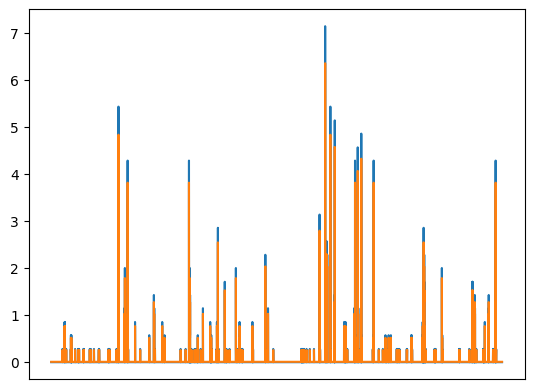

In [24]:
x1 = projected_by_intensity.datetime[:]
y1 = projected_by_intensity.pr[:]

x2 = x1
y2 = projected_by_intensity.projected_pr[:]
plt.xticks([])
plt.xlim()

plt.plot(x2, y2, x1, y1, label='Projected Precipitation')

plt.show

<function matplotlib.pyplot.show(close=None, block=None)>

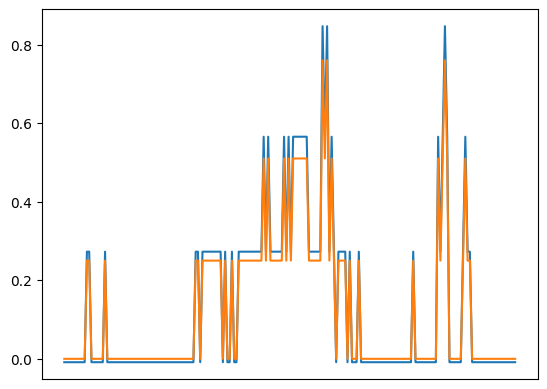

In [25]:
x1 = projected_by_intensity.datetime[3050:3250]
y1 = projected_by_intensity.pr[3050:3250]

x2 = x1
y2 = projected_by_intensity.projected_pr[3050:3250]

# plt.figure(figsize=(18,15))
plt.xticks([])
plt.xlim()

plt.plot(x2, y2, x1, y1, label='Projected Precipitation')

plt.show

- Do something to remove negative values
- Further analysis
- How to make scrollable plot?
- Add labels to plots
- How does the projection compare to the original?
- How do the methods compare to one another? 
- Hide futurewarning or fix the thing that's causing it
- Set up .yaml with current versions of packages to future proof
- Rerun trim function to see if it still adds unnamed column. If so, fix.
- Benefits of having multiple notebooks vs only one? Since it's a notebook instead of a script, one might be better, and the markdown can be used to clearly denote what's happening
- Check effects of bucketing
- Try plotting CDF to see if it makes sense. Weird that no rain = CDF of ~.5
- histogram of storm duration from past to future to see if duration tends to increase or decrease - look at nonbucketed, but could use bins when plotting/showing results
- Did I keep zeros in when using the first method (not in this doc)? What are the implications of keeping/removing the zeros --- yes
- For bucket method (change to bin), duration of storm and number of time steps where one value for pr_sum appear in the data are probably skewing the CDF. Change to calculate stats based on non-merged dataset (trimmed.csv)